#Определение проблемы

Cookie Cats — это чрезвычайно популярная мобильная головоломка, разработанная компанией Tactile Entertainment. Это классическая головоломка в стиле "соедините три", где игрок должен соединять плитки одного цвета, чтобы очистить поле и пройти уровень.

По мере прохождения уровней игры игроки время от времени сталкиваются с воротами, которые заставляют их ждать непродолжительное время или сделать покупку внутри приложения, чтобы продолжить игру.

Но где должны быть размещены ворота? Изначально первые ворота были размещены на уровне 30. **Моей задачей будет провести A/B-тест, чтобы понять улучшатся ли метрики при перемещении ворот на 40 уровень.**

В частности, я рассмотрю влияние на удержание игроков.

**Основные метрики:**

Удержание игроков (player retention) и увеличение длины сессии(session increase).

**Вопросы:**


1. Увеличилось ли среднее количество игровых сессий на 5 сессий?
2. Увеличилось ли удержание игроков на 2% через 1 день?
3. Увеличилось ли удержание игроков на 5% через 7 дней?

#Описание данных

**Данные для анализа A/B-теста включают:**

* userid: Уникальный идентификатор игрока.

* version: Группа, в которую попал игрок (контрольная группа с воротами на уровне 30 или группа с перемещенными воротами на уровне 40).

* sum_gamerounds: Количество сыгранных раундов игры в течение первых 14 дней после установки.

* retention_1: Возвращался ли игрок через 1 день после установки?

* retention_7: Возвращался ли игрок через 7 дней после установки?

#Импорт библиотек и загрузка датасета

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as stats
import statsmodels.stats.api as sms
import statsmodels.api as sm
df = pd.read_csv('cookie_cats.txt')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


#Вопрос 1

##Обзор данных

In [4]:
import scipy.stats as stats

# Разделение данных на контрольную и тестовую группы по 'version'
df_control = df[df['version'] == 'gate_30']
df_test = df[df['version'] == 'gate_40']

continuous_var = ['sum_gamerounds']

def calculate_statistics(df, continuous_var, group_name, confidence_level=0.95):
    # Рассчёт основных статистик
    concatenated_series = pd.concat([
        df[continuous_var].describe().T,
        df[continuous_var].skew().rename('Ассиметрия'),
        df[continuous_var].kurtosis().rename('Эксцесс')
    ], axis=1)

    # Расчет доверительных интервалов для среднего значения
    for var in continuous_var:
        values = df[var].dropna()
        mean = values.mean()
        std_error = stats.sem(values)
        if std_error != 0:
            lower, upper = stats.t.interval(confidence_level, len(values) - 1, loc=mean, scale=std_error)
        else:
            lower, upper = mean, mean

        concatenated_series.loc[var, f"Нижняя граница {confidence_level}%"] = lower
        concatenated_series.loc[var, f"Верхняя граница {confidence_level}%"] = upper

    concatenated_series['Группа'] = group_name

    return concatenated_series

# Рассчёт статистики для контрольной группы
control_stats = calculate_statistics(df_control, continuous_var, 'control')

# Рассчёт статистики для тестовой группы
test_stats = calculate_statistics(df_test, continuous_var, 'test')

# Объединение статистики для обеих групп
combined_stats = pd.concat([control_stats, test_stats])

# Сброс индекса для удобства отображения
combined_stats.reset_index(inplace=True)

combined_stats

,index,count,mean,std,min,25%,50%,75%,max,Ассиметрия,Эксцесс,Нижняя граница 0.95%,Верхняя граница 0.95%,Группа
0,sum_gamerounds,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0,163.709871,31688.380643,50.076358,54.836170,control
1,sum_gamerounds,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0,5.967288,63.106084,50.349520,52.248031,test


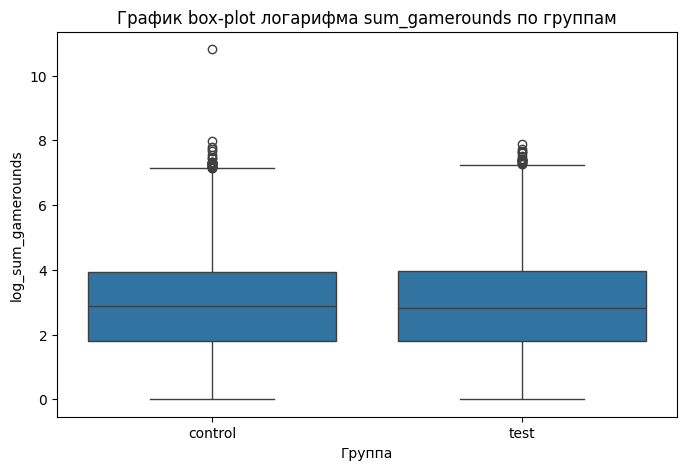

In [6]:

df_control['group'] = 'control'
df_test['group'] = 'test'

df_combined = pd.concat([df_control, df_test])

#логарифмическое преобразование к 'sum_gamerounds'
df_combined['log_sum_gamerounds'] = np.log1p(df_combined['sum_gamerounds'])  # log1p для обработки нулевых значений

plt.figure(figsize=(8, 5))

sns.boxplot(x='group', y='log_sum_gamerounds', data=df_combined)

# Добавим заголовок и метки осей
plt.title('График box-plot логарифма sum_gamerounds по группам')
plt.xlabel('Группа')
plt.ylabel('log_sum_gamerounds')

# Отобразимграфик
plt.show()

In [7]:
#Удалим выброс в контрольной группе, чтобы не мешал
max_value = df_control['sum_gamerounds'].max()
df_control = df_control[df_control['sum_gamerounds'] != max_value]


##Вычисление размера выборки

In [11]:
# Установим желаемые ошибки первого и второго рода
alpha = 0.05
beta = 0.2

Z = (norm.ppf(1-(alpha/2), loc=0, scale=1) + norm.ppf(1-beta, loc=0, scale=1))**2
var = pd.concat([df_control['sum_gamerounds'],df_test['sum_gamerounds']]).var()

expected_effect_size = 5

#Рассчитаем размер выборки
sample_size = (Z*2*var)/(expected_effect_size**2)

print(sample_size.astype('int'))

6620


##Деление на группы

In [13]:
def choose_random_sample(data):
    return data.sample(n=int(sample_size), random_state=42)

df_control_smpl = df_control.apply(choose_random_sample)
df_test_smpl = df_test.apply(choose_random_sample)

print(df_control_smpl)
print(df_test_smpl)

        userid  version  sum_gamerounds  retention_1  retention_7    group
58981  6531088  gate_30              55         True        False  control
72248  8003089  gate_30               2        False        False  control
50215  5566807  gate_30              23         True        False  control
609      64235  gate_30               1        False        False  control
56038  6210551  gate_30               7        False        False  control
...        ...      ...             ...          ...          ...      ...
48336  5360248  gate_30               0        False        False  control
19558  2177537  gate_30               9        False        False  control
32381  3601437  gate_30               2         True        False  control
30133  3356288  gate_30              71        False        False  control
63009  6982177  gate_30               1        False        False  control

[6620 rows x 6 columns]
        userid  version  sum_gamerounds  retention_1  retention_7 group
405

##Расчет статистики и результаты

In [16]:
# Проведение T-теста для проверки равенства средних в двух группах
t_stat, p_value = stats.ttest_ind(df_control_smpl['sum_gamerounds'], df_test_smpl['sum_gamerounds'], equal_var=False)

# Рассчет средних значений в обеих группах
mean_control = df_control_smpl['sum_gamerounds'].mean()
mean_test = df_test_smpl['sum_gamerounds'].mean()

# Вывод результатов
print(f'Среднее значение в контрольной группе: {mean_control:.2f}')
print(f'Среднее значение в тестовой группе: {mean_test:.2f}')
print(f'Значение статистики T: {t_stat:.4f}')
print(f'p-значение: {p_value:.4f}')

# Проверка гипотезы
alpha = 0.05
if p_value < alpha:
    print('Отвергнули нулевую гипотезу: средние значения в группах статистически различаются.')
else:
    print('Невозможно отвергнуть нулевую гипотезу: нет статистически значимого различия между средними значениями в группах.')

Среднее значение в контрольной группе: 50.78
Среднее значение в тестовой группе: 51.75
Значение статистики T: -0.5589
p-значение: 0.5762
Невозможно отвергнуть нулевую гипотезу: нет статистически значимого различия между средними значениями в группах.


**Резюме:** Не удалось зафиксировать значимое отклонение. Размещение ворот на уровне 40 может быть неэффективной стратегией для увеличения количества игровых сессий.

#Вопрос 2

##Создание таблицы сопряженности

In [19]:
# Создание таблицы сопряженности
contingency_table = pd.crosstab(df['version'], df['retention_1'])

print("Таблица сопряженности с частотами:")
print(contingency_table)
print("-"*40)

# Рассчет процентного соотношения по строкам
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nПроцентное соотношение по строкам:")
print(row_percentages)

Таблица сопряженности с частотами:
retention_1  False  True 
version                  
gate_30      24666  20034
gate_40      25370  20119
----------------------------------------

Процентное соотношение по строкам:
retention_1      False      True 
version                          
gate_30      55.181208  44.818792
gate_40      55.771725  44.228275


**Промежуточный вывод:** По таблице сопряженности видно, что изменение не дало результатов. Я продолжу исследование, хотя результат уже очевиден.

##Рассчет размера выборки

In [ ]:

alpha = 0.05        # Уровень значимости
power = 0.8        # Мощность

p1 = row_percentages.iloc[0,1]
p2 = p1 + 0.02

es = sms.proportion_effectsize(p1, p2)

sample_size = sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)

print(f"Необходимый размер выборки: {sample_size:}")

##Деление на группы

In [22]:
sample_size = 9741


df_smpl = df.groupby('version', group_keys=False).apply(choose_random_sample)

print(df_smpl)

        userid  version  sum_gamerounds  retention_1  retention_7
58980  6531033  gate_30              35        False        False
72247  8003009  gate_30               4        False        False
50215  5566807  gate_30              23         True        False
609      64235  gate_30               1        False        False
56038  6210551  gate_30               7        False        False
...        ...      ...             ...          ...          ...
39239  4345769  gate_40             201        False         True
67816  7514840  gate_40              40         True        False
46713  5179197  gate_40              16        False        False
60827  6740993  gate_40              26        False        False
64794  7177645  gate_40               1        False        False

[19482 rows x 5 columns]


##Визуализируем пропорции

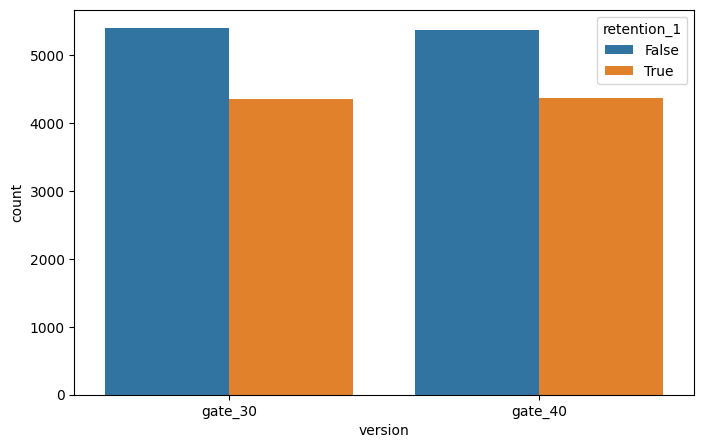

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(df_smpl, x='version', hue='retention_1', ax=ax)

plt.show()

In [28]:
#Проведем Z-тест
# Создание таблицы сопряженности
contingency_table = pd.crosstab(df_smpl['version'], df_smpl['retention_1'])

print("Таблица сопряженности с частотами:")
print(contingency_table)
print("-"*40)

# Рассчет процентного соотношения по строкам
row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nПроцентное соотношение по строкам:")
print(row_percentages)
print("-"*40)

# Подсчет количества успехов (конверсий) и испытаний в каждой группе
success_A = contingency_table.iloc[0,1]
trials_A = contingency_table.iloc[0,0] + contingency_table.iloc[0,1]

success_B = contingency_table.iloc[1,1]
trials_B = contingency_table.iloc[1,0] + contingency_table.iloc[1,1]

# Проведение Z-теста для пропорций
z_stat, p_value = sm.stats.proportions_ztest([success_A, success_B], [trials_A, trials_B], alternative='smaller') #  [‘two-sided’, ‘smaller’, ‘larger’]

# Вывод результатов
print(f"Z-статистика: {z_stat:.4f}")
print(f"P-значение: {p_value:.4f}")

# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print('Отвергнули нулевую гипотезу: средние значения в группах статистически различаются.')
else:
    print('Невозможно отвергнуть нулевую гипотезу: нет статистически значимого различия между средними значениями в группах.')

Таблица сопряженности с частотами:
retention_1  False  True 
version                  
gate_30       5394   4347
gate_40       5370   4371
----------------------------------------

Процентное соотношение по строкам:
retention_1      False      True 
version                          
gate_30      55.374192  44.625808
gate_40      55.127810  44.872190
----------------------------------------
Z-статистика: -0.3458
P-значение: 0.3647
Невозможно отвергнуть нулевую гипотезу: нет статистически значимого различия между средними значениями в группах.


**Резюме:** Вторую гипотезу также не удалось подтвердить.

#Вопрос 3

##Создание таблицы сопряженности

In [29]:
contingency_table = pd.crosstab(df['version'], df['retention_7'])

print("Таблица сопряженности с частотами:")
print(contingency_table)
print("-"*40)

row_percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\nПроцентное соотношение по строкам:")
print(row_percentages)

Таблица сопряженности с частотами:
retention_7  False  True 
version                  
gate_30      36198   8502
gate_40      37210   8279
----------------------------------------

Процентное соотношение по строкам:
retention_7      False      True 
version                          
gate_30      80.979866  19.020134
gate_40      81.799996  18.200004


**Резюме:** Как и во втором вопросе, все видно уже на этапе обзора данных. Не нужно проводить A/B-тест, когда понятно, что статистически значимых отличий нет. Наше нововведение не позволило улучшить retention.